<a href="https://colab.research.google.com/github/Gnac05/benin-budget-allocation-model/blob/main/benin_budget_optim_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Optimisation de l'allocation budgétaire (Bénin) – Notebook Colab (docplex/CPLEX)

Ce notebook **Google Colab** implémente, en **Python** avec **docplex/cplex**, les modèles issus des scripts R :
- `04_model_epsilon.R` (**modèle ε-contrainte**),
- `04_model_variants.R` (**modèle pondéré** + **équité / concentration**),
- `04_scenarios.R` (**scénarios** : SAA et Min–Max).

### 🔧 Prérequis
- Compte Google pour Colab.
- Fichiers **CSV** préparés (sortis du Chapitre 2) :
  - `features_programme.csv` avec au minimum les colonnes :  
    `programme_id, programme_name, fonction_de_l_etat, E_n, R_n, F_n`  
    *(Si `F_n` est absent, le notebook peut le recalculer à partir de `E_n`, `R_n` et d’un poids `OMEGA`.)*
  - **Optionnel** : `programme_annee_clean.csv` avec :  
    `annee, programme_id, programme_name, fonction_de_l_etat, prevision, ordonnancementent`  
    *(utile pour calculer des bornes réalistes x_min/x_max et un budget `B` par défaut).*

> 💡 **Conseil** : placez vos fichiers dans Google Drive (ou utilisez l’upload direct Colab).


In [ ]:

# === Installation des packages (exécuter dans Colab) ===
# Si vous exécutez localement sans internet, commentez la ligne pip.
!pip -q install docplex cplex pandas numpy matplotlib


In [ ]:

import sys, os, math, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, Dict, Any

try:
    import docplex.mp
    from docplex.mp.model import Model
    print("docplex Import success")
except Exception as e:
    print("ERREUR: docplex introuvable ->", e)

try:
    import cplex
    print("cplex version:", cplex.__version__)
except Exception as e:
    print("AVERTISSEMENT: module 'cplex' introuvable. docplex tentera d'utiliser un solveur compatible.")


docplex Import success
cplex version: 22.1.2.0


In [ ]:
# === Accès aux fichiers ===
# Option A (recommandée) : MONTER GOOGLE DRIVE
# from google.colab import drive
# drive.mount('/content/drive')
PATH_DATA = "/content/drive/MyDrive/Colab Notebooks/memoire-gmm"  # ajustez si besoin

# Option B : UPLOAD DIRECT
# from google.colab import files
# uploaded = files.upload()  # uploadez ici vos CSV si vous préférez

# Répertoire courant par défaut :
# PATH_DATA = './memoire-gmm' # Ajusté selon la clarification

# Noms de fichier attendus (ajustez si vous avez d'autres noms)
FEATURES_CSV = os.path.join(PATH_DATA, 'features_programmes.csv')
HIST_CSV     = os.path.join(PATH_DATA, 'programmes_annee_clean.csv')  # optionnel
OUT_DIR      = os.path.join(PATH_DATA, 'outputs_py')
os.makedirs(OUT_DIR, exist_ok=True)

print("Répertoire de travail:", os.getcwd())
print("Sorties ->", OUT_DIR)

Répertoire de travail: /content
Sorties -> /content/drive/MyDrive/Colab Notebooks/memoire-gmm/outputs_py


In [ ]:

# === Paramètres globaux (ajustez à votre contexte) ===
BUDGET_TOTAL = 1668636322006# si None, calculé à partir de l'historique ou à saisir
TAU_SOCLE    = 0.60      # seuil d'efficacité agrégée (ε-contrainte)
OMEGA        = 0.50      # poids E vs R* dans F si recalcul (moyenne géométrique par défaut)
AGG_TYPE     = 'geo'     # 'geo' | 'harm' | 'arith'
XMIN_FACTOR  = 0.50      # x_min = 50% de l'ordonnancé médian (si HIST_CSV dispo)
XMAX_FACTOR  = 1.20      # x_max = 120% de l'ordonnancé max (si HIST_CSV dispo)

# === Fonctions utilitaires ===
def normalize_minmax(x: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    m, M = np.nanmin(x), np.nanmax(x)
    return (x - m) / (M - m + eps) if np.isfinite(M-m) and (M - m) > eps else np.zeros_like(x)

def efficience_agg(E: np.ndarray, R_star: np.ndarray, omega: float = 0.5, agg: str = 'geo') -> np.ndarray:
    E = np.clip(E, 1e-12, 1.0)
    R_star = np.clip(R_star, 1e-12, 1.0)
    if agg == 'geo':
        return (E ** omega) * (R_star ** (1 - omega))
    if agg == 'harm':
        return 1.0 / ( (omega / E) + ((1 - omega) / R_star) )
    if agg == 'arith':
        return omega * E + (1 - omega) * R_star
    raise ValueError("agg doit être parmi {'geo','harm','arith'}.")

def prepare_bounds_from_history(hist_df: pd.DataFrame) -> pd.DataFrame:
    grp = (hist_df
           .groupby('programme_id', as_index=False)
           .agg(ord_max=('ordonnancement','max'),
                ord_med=('ordonnancement','median')))
    grp['x_min'] = np.maximum(0.0, XMIN_FACTOR * grp['ord_med'].fillna(0.0))
    grp['x_max'] = np.maximum(1.0, XMAX_FACTOR * grp['ord_max'].fillna(0.0))
    return grp[['programme_id','x_min','x_max']]

def decide_budget_total(hist_df: pd.DataFrame) -> float:
    # Par défaut : budget = somme de l'ordonnancé médian (approximation conservative)
    budget = hist_df.groupby('programme_id', as_index=False)['ordonnancement'].median()['ordonnancement'].sum()
    return float(budget if np.isfinite(budget) and budget > 0 else 0.0)


In [ ]:
# === Chargement des données ===
features = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/memoire-gmm/features_programme.csv")
print("features_programmes.csv ->", features.shape)

if os.path.exists("/content/drive/MyDrive/Colab Notebooks/memoire-gmm/programme_annee_clean.csv"):
    hist = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/memoire-gmm/programme_annee_clean.csv")
    print("programme_annee_clean.csv ->", hist.shape)
else:
    hist = None
    print("programme_annee_clean.csv non trouvé (bornes et B seront générés par défaut).")

# Colonnes minimales attendues
min_cols = {'programme_id','E_n','R_n'}
assert min_cols.issubset(set(features.columns)), f"Colonnes manquantes dans features: {min_cols - set(features.columns)}"

# Si F_n manquant, on le calcule
if 'F_n' not in features.columns:
    features['F_n'] = efficience_agg(features['E_n'].values, features['R_n'].values, omega=OMEGA, agg=AGG_TYPE)
    features['F_n'] = normalize_minmax(features['F_n'].values)
    print("F_n recalculé et normalisé.")

# Bornes x_min/x_max
if hist is not None and {'programme_id','ordonnancement'}.issubset(set(hist.columns)):
    bounds = prepare_bounds_from_history(hist)
else:
    # Sans historique : bornes larges
    bounds = features[['programme_id']].copy()
    bounds['x_min'] = 0.0
    bounds['x_max'] = 1e12  # plafond très large par défaut
    print("Bornes x_min/x_max par défaut (pas d'historique).")

# Fusion
dat = (features.merge(bounds, on='programme_id', how='left')
                .fillna({'x_min':0.0, 'x_max':1e12}))

# Budget total
if BUDGET_TOTAL is None:
    if hist is not None and {'programme_id','ordonnancement'}.issubset(set(hist.columns)):
        BUDGET_TOTAL = decide_budget_total(hist)
        print(f"BUDGET_TOTAL estimé depuis l'historique (médians ordonnancés) = {BUDGET_TOTAL:,.2f}")
    else:
        BUDGET_TOTAL = dat['x_max'].replace(np.inf, np.nan).median() * len(dat) * 0.2
        print(f"BUDGET_TOTAL par défaut = {BUDGET_TOTAL:,.2f} (à ajuster)")

# Préparer les vecteurs
program_ids = dat['programme_id'].astype(str).tolist()
E = dat['E_n'].values.astype(float)
F = dat['F_n'].values.astype(float)
xmin = dat['x_min'].values.astype(float)
xmax = dat['x_max'].values.astype(float)
B = float(BUDGET_TOTAL)

print("n programmes:", len(program_ids))

features_programmes.csv -> (70, 14)
programme_annee_clean.csv -> (139, 10)
n programmes: 70


In [ ]:
print("BUDGET_TOTAL : ", B)

print("Programm ID : ", program_ids[1])

print("x_min[1]=", xmin[1]) #2203526964.0

print("x_max[1]=", xmax[1])

print("sum(x_min) = ", sum(xmin))
print("Difference BUDGET_TOTAL and x_min :", B-sum(xmin))
print("sum(x_max) = ", sum(xmax))
print("Difference BUDGET_TOTAL and x_max :", B-sum(xmax))

BUDGET_TOTAL :  1668636322006.0
Programm ID :  P016
x_min[1]= 1015605702.75
x_max[1]= 3120504061.2
sum(x_min) =  551273346038.25
Difference BUDGET_TOTAL and x_min : 1117362975967.75
sum(x_max) =  1531941738009.6
Difference BUDGET_TOTAL and x_max : 136694583996.3999


In [ ]:
# === Modèle ε-contrainte : max sum F_i x_i  s.c. sum E_i x_i >= tau*B ; sum x_i = B ; xmin <= x_i <= xmax ===
mdl = Model(name="epsilon_contrainte")
x = mdl.continuous_var_list(len(program_ids), lb=0, ub=None, name="x")

# Bornes opérationnelles
for i in range(len(program_ids)):
    if np.isfinite(xmin[i]):
        mdl.add_constraint(x[i] >= xmin[i])
    if np.isfinite(xmax[i]):
        mdl.add_constraint(x[i] <= xmax[i])

# Bouclage budgétaire
mdl.add_constraint(mdl.sum(x) <= B)

# Socle d'efficacité agrégée
# Construire l'expression linéaire explicitement
efficiency_expr = mdl.scal_prod(x, E)
mdl.add_constraint(efficiency_expr >= TAU_SOCLE * B)

# Objectif
mdl.maximize(mdl.dot(x, F))

# Résolution
sol = mdl.solve(log_output=True)
if sol is None:
    print("Pas de solution trouvée. Vérifiez les bornes et le paramètre TAU_SOCLE.")
else:
    alloc_eps = pd.DataFrame({
        'programme_id': program_ids,
        'x_star': [sol.get_value(v) for v in x]
    })
    alloc_eps['part'] = alloc_eps['x_star'] / B
    out_path = os.path.join(OUT_DIR, 'allocation_epsilon.csv')
    alloc_eps.to_csv(out_path, index=False)
    print("Solution ε-contrainte enregistrée ->", out_path)
    display(alloc_eps.head(10))

Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 142 rows and 70 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.05 ticks)
Solution ε-contrainte enregistrée -> /content/drive/MyDrive/Colab Notebooks/memoire-gmm/outputs_py/allocation_epsilon.csv


,programme_id,x_star,part
0,P015,3.810916e+09,0.002284
1,P016,3.120504e+09,0.001870
2,P018,4.293639e+09,0.002573
3,P019,9.131089e+08,0.000547
4,P020,1.421020e+10,0.008516
5,P021,6.207790e+08,0.000372
6,P022,4.047947e+09,0.002426
7,P023,1.663445e+09,0.000997
8,P026,5.384788e+09,0.003227
9,P027,6.464749e+09,0.003874


In [ ]:

# === Modèle pondéré : max sum [alpha*E + (1-alpha)*F] x_i  s.c. sum x_i = B ; bornes ===
ALPHA = 0.30  # poids de E dans le score combiné S
S = ALPHA * E + (1 - ALPHA) * F

mdl_w = Model(name="weighted_model")
xw = mdl_w.continuous_var_list(len(program_ids), lb=0, ub=None, name="x")

# Bornes
for i in range(len(program_ids)):
    if np.isfinite(xmin[i]):
        mdl_w.add_constraint(xw[i] >= xmin[i])
    if np.isfinite(xmax[i]):
        mdl_w.add_constraint(xw[i] <= xmax[i])

# Budget
mdl_w.add_constraint(mdl_w.sum(xw) <= B)

# Objectif
mdl_w.maximize(mdl_w.dot(xw, S))

sol_w = mdl_w.solve(log_output=True)
if sol_w is None:
    print("Pas de solution pour le modèle pondéré. Vérifiez les bornes.")
else:
    alloc_w = pd.DataFrame({
        'programme_id': program_ids,
        'x_star': [sol_w.get_value(v) for v in xw]
    })
    alloc_w['part'] = alloc_w['x_star'] / B
    out_path = os.path.join(OUT_DIR, 'allocation_weighted.csv')
    alloc_w.to_csv(out_path, index=False)
    print("Solution pondérée enregistrée ->", out_path)
    display(alloc_w.head(10))


Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 141 rows and 70 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.04 ticks)
Solution pondérée enregistrée -> /content/drive/MyDrive/Colab Notebooks/memoire-gmm/outputs_py/allocation_weighted.csv


,programme_id,x_star,part
0,P015,3.810916e+09,0.002284
1,P016,3.120504e+09,0.001870
2,P018,4.293639e+09,0.002573
3,P019,9.131089e+08,0.000547
4,P020,1.421020e+10,0.008516
5,P021,6.207790e+08,0.000372
6,P022,4.047947e+09,0.002426
7,P023,1.663445e+09,0.000997
8,P026,5.384788e+09,0.003227
9,P027,6.464749e+09,0.003874


In [ ]:
# === Variante équité : QP avec contrainte de concentration (Herfindahl) ===
# HHI = sum_i (x_i / B)^2 <= DELTA
DELTA = 0.15  # cible indicative : plus petit = moins concentré

mdl_h = Model(name="equity_hhi_qp")
xh = mdl_h.continuous_var_list(len(program_ids), lb=0, ub=None, name="x")

# Bornes
for i in range(len(program_ids)):
    if np.isfinite(xmin[i]):
        mdl_h.add_constraint(xh[i] >= xmin[i])
    if np.isfinite(xmax[i]):
        mdl_h.add_constraint(xh[i] <= xmax[i])

# Budget
mdl_h.add_constraint(mdl_h.sum(xh) <= B)

# Objectif = même score S que le modèle pondéré (peut être ajusté)
mdl_h.maximize(mdl_h.dot(xh, S))

# Contrainte quadratique de concentration
# sum (xh[i]/B)^2 <= DELTA  -> sum xh[i]^2 <= DELTA * B^2
quad_expr = mdl_h.sum(xh[i] * xh[i] for i in range(len(program_ids)))
mdl_h.add_quadratic_constraints([quad_expr <= DELTA * (B ** 2)]) # Wrap the constraint in a list

sol_h = mdl_h.solve(log_output=True)
if sol_h is None:
    print("Pas de solution pour le modèle équité (QP). Ajustez DELTA ou les bornes.")
else:
    alloc_h = pd.DataFrame({
        'programme_id': program_ids,
        'x_star': [sol_h.get_value(v) for v in xh]
    })
    alloc_h['part'] = alloc_h['x_star'] / B
    out_path = os.path.join(OUT_DIR, 'allocation_weighted_equity_hhi.csv')
    alloc_h.to_csv(out_path, index=False)
    print("Solution équité (HHI) enregistrée ->", out_path)
    display(alloc_h.head(10))

Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Presolve time = 0.00 sec. (0.03 ticks)
Pas de solution pour le modèle équité (QP). Ajustez DELTA ou les bornes.


In [ ]:

# === Scénarios : génération + SAA et Min–Max ===
rng = np.random.default_rng(20240923)

S_nb = 50  # nombre de scénarios
E0 = E.copy()
R0 = dat['R_n'].values.astype(float)

# Écarts-types (sobres) : si pas disponibles, on pose des valeurs petites mais non nulles
E_sd = np.full_like(E0, 0.05, dtype=float)
R_sd = np.full_like(R0, 0.05, dtype=float)

# Tirages tronqués dans [0,1]
def draw_trunc_normal(mean, sd, size):
    arr = rng.normal(loc=mean, scale=sd, size=size)
    return np.clip(arr, 0.0, 1.0)

E_scen = np.stack([draw_trunc_normal(E0, E_sd, E0.shape) for _ in range(S_nb)], axis=1)  # (n, S)
R_scen = np.stack([draw_trunc_normal(R0, R_sd, R0.shape) for _ in range(S_nb)], axis=1)  # (n, S)

# Calcul F par scénario + normalisation par scénario (option)
def compute_F_scen(E_s, R_s, omega=OMEGA, agg=AGG_TYPE):
    F_s = np.empty_like(E_s)
    for s in range(E_s.shape[1]):
        F = efficience_agg(E_s[:,s], R_s[:,s], omega=omega, agg=agg)
        F_s[:,s] = normalize_minmax(F)
    return F_s

F_scen = compute_F_scen(E_scen, R_scen, omega=OMEGA, agg=AGG_TYPE)

# === SAA : max (1/S) * sum_s sum_i F_i^s x_i  s.c.  sum_i E_i^s x_i >= tau B ; sum_i x_i = B  ===
mdl_saa = Model(name="saa_expectation")
xs = mdl_saa.continuous_var_list(len(program_ids), lb=0, ub=None, name="x")

# Bornes
for i in range(len(program_ids)):
    if np.isfinite(xmin[i]):
        mdl_saa.add_constraint(xs[i] >= xmin[i])
    if np.isfinite(xmax[i]):
        mdl_saa.add_constraint(xs[i] <= xmax[i])

# Budget constant (recommandé)
mdl_saa.add_constraint(mdl_saa.sum(xs) <= B)

# Efficacité par scénario
for s in range(S_nb):
    mdl_saa.add_constraint(mdl_saa.dot(xs, E_scen[:,s]) >= TAU_SOCLE * B)

# Objectif SAA
mdl_saa.maximize( (1.0 / S_nb) * mdl_saa.sum( mdl_saa.dot(xs, F_scen[:,s]) for s in range(S_nb) ) )

sol_saa = mdl_saa.solve(log_output=True)
if sol_saa is None:
    print("Pas de solution SAA. Desserrez TAU_SOCLE ou les bornes.")
else:
    alloc_saa = pd.DataFrame({
        'programme_id': program_ids,
        'x_star': [sol_saa.get_value(v) for v in xs]
    })
    alloc_saa['part'] = alloc_saa['x_star'] / B
    out_path = os.path.join(OUT_DIR, 'allocation_saa.csv')
    alloc_saa.to_csv(out_path, index=False)
    print("Solution SAA enregistrée ->", out_path)
    display(alloc_saa.head(10))

# === Min–Max : max z  s.c.  z <= sum_i F_i^s x_i,  sum_i E_i^s x_i >= tau B,  sum_i x_i = B ===
mdl_mm = Model(name="minmax_worstcase")
xm = mdl_mm.continuous_var_list(len(program_ids), lb=0, ub=None, name="x")
z  = mdl_mm.continuous_var(lb=-mdl_mm.infinity, name="z")

# Bornes
for i in range(len(program_ids)):
    if np.isfinite(xmin[i]):
        mdl_mm.add_constraint(xm[i] >= xmin[i])
    if np.isfinite(xmax[i]):
        mdl_mm.add_constraint(xm[i] <= xmax[i])

# Budget
mdl_mm.add_constraint(mdl_mm.sum(xm) <= B)

# Contraintes par scénario
for s in range(S_nb):
    mdl_mm.add_constraint(z <= mdl_mm.dot(xm, F_scen[:,s]))
    mdl_mm.add_constraint(mdl_mm.dot(xm, E_scen[:,s]) >= TAU_SOCLE * B)

mdl_mm.maximize(z)

sol_mm = mdl_mm.solve(log_output=True)
if sol_mm is None:
    print("Pas de solution Min–Max. Ajustez les paramètres.")
else:
    alloc_mm = pd.DataFrame({
        'programme_id': program_ids,
        'x_star': [sol_mm.get_value(v) for v in xm]
    })
    alloc_mm['part'] = alloc_mm['x_star'] / B
    out_path = os.path.join(OUT_DIR, 'allocation_minmax.csv')
    alloc_mm.to_csv(out_path, index=False)
    print("Solution Min–Max enregistrée ->", out_path)
    display(alloc_mm.head(10))


Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 191 rows and 70 columns.
All rows and columns eliminated.
Presolve time = 0.01 sec. (0.33 ticks)
Solution SAA enregistrée -> /content/drive/MyDrive/Colab Notebooks/memoire-gmm/outputs_py/allocation_saa.csv


,programme_id,x_star,part
0,P015,3.810916e+09,0.002284
1,P016,3.120504e+09,0.001870
2,P018,4.293639e+09,0.002573
3,P019,9.131089e+08,0.000547
4,P020,1.421020e+10,0.008516
5,P021,6.207790e+08,0.000372
6,P022,4.047947e+09,0.002426
7,P023,1.663445e+09,0.000997
8,P026,5.384788e+09,0.003227
9,P027,6.464749e+09,0.003874


Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 241 rows and 71 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.64 ticks)
Solution Min–Max enregistrée -> /content/drive/MyDrive/Colab Notebooks/memoire-gmm/outputs_py/allocation_minmax.csv


,programme_id,x_star,part
0,P015,3.810916e+09,0.002284
1,P016,3.120504e+09,0.001870
2,P018,4.293639e+09,0.002573
3,P019,9.131089e+08,0.000547
4,P020,1.421020e+10,0.008516
5,P021,6.207790e+08,0.000372
6,P022,4.047947e+09,0.002426
7,P023,1.663445e+09,0.000997
8,P026,5.384788e+09,0.003227
9,P027,6.464749e+09,0.003874


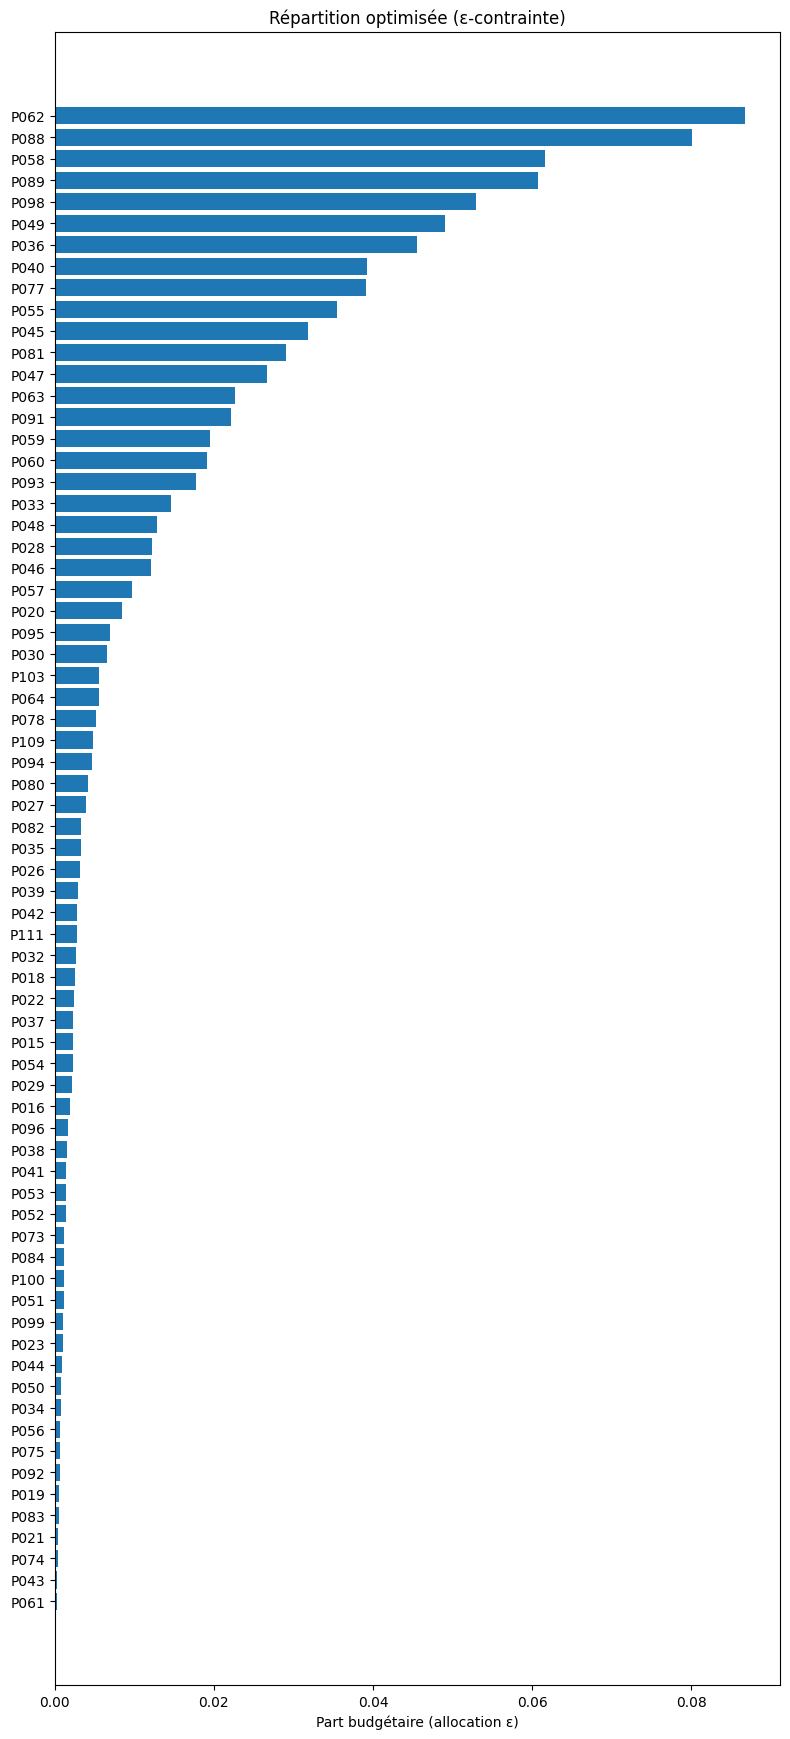

In [ ]:

# === Visualisation : parts budgétaires optimisées (ε-contrainte) ===
try:
    df_plot = pd.read_csv(os.path.join(OUT_DIR, 'allocation_epsilon.csv'))
    df_plot = df_plot.sort_values('part', ascending=False).reset_index(drop=True)
    plt.figure(figsize=(8, max(6, len(df_plot)*0.25)))
    plt.barh(df_plot['programme_id'].astype(str), df_plot['part'])
    plt.gca().invert_yaxis()
    plt.xlabel('Part budgétaire (allocation ε)')
    plt.title('Répartition optimisée (ε-contrainte)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Impossible d’afficher la figure (allocation_epsilon.csv manquant ?)", e)
